In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # from scipy.misc import imresize
from tqdm import tqdm
import nibabel

In [4]:
def read_train_exam(exam_nb):
    image = nibabel.load('../chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('../chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('../chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [5]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [6]:
image_1, mask_1 = read_train_exam(2)


In [13]:
print("before scale {},{},".format(np.unique(mask_1.get_data()),np.unique(image_1.get_data())))

before scale [0 1 2 3 4],[   0    1    2 ... 1474 1501 1503],


In [14]:
print("after scale {},{}".format(np.unique(preprocess(mask_1)),np.unique(preprocess(image_1))))

after scale [0.       0.015625 0.015625 ... 3.984375 3.984375 4.      ],[0.00000000e+00 1.56250000e-02 1.56250000e-02 ... 1.45790625e+03
 1.46843750e+03 1.48428125e+03]


In [43]:
def mask_to_channels(mask,init,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(init,classes)])
    img = np.swapaxes(img,0,-1)#new shape (row,col,class)
    print(img.shape)
    return img

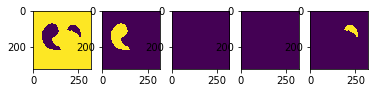

In [34]:
test = mask_1.get_data()[:,:,15]
img = mask_to_channels(test,0,5)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(img[:,:,i])
plt.show()

In [68]:
def create_data_train(train_ids = [1,2,3,5,8,10,13,19],background = 0):
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        #transform le mask
        if background:
            #create mask for 5 classess
            mask = mask_to_channels(mask,0,5)[0]
        else:
            mask = mask_to_channels(mask,1,5)[0]            
       
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('./dataset/imgs_train_{}'.format(background), imgs=train_data)
    np.savez_compressed('./dataset/imgs_mask_train_{}'.format(background), imgs_mask=train_mask)

In [46]:
#dataset training without background
create_data_train()

1it [00:00,  3.35it/s]

(1, 36, 256, 256, 4)


2it [00:00,  3.18it/s]

(1, 26, 256, 256, 4)


3it [00:01,  2.44it/s]

(1, 30, 256, 256, 4)


4it [00:01,  2.46it/s]

(1, 30, 256, 256, 4)


5it [00:02,  2.29it/s]

(1, 32, 256, 256, 4)
(1, 36, 256, 256, 4)


6it [00:02,  2.14it/s]

(1, 30, 256, 256, 4)


7it [00:03,  1.94it/s]

(1, 30, 256, 256, 4)


8it [00:04,  1.71it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 4)


In [48]:
#dataset training without background
create_data_train(background=1)

1it [00:00,  3.06it/s]

(1, 36, 256, 256, 5)


2it [00:00,  2.92it/s]

(1, 26, 256, 256, 5)


3it [00:01,  2.61it/s]

(1, 30, 256, 256, 5)


4it [00:01,  2.50it/s]

(1, 30, 256, 256, 5)
(1, 32, 256, 256, 5)


5it [00:02,  2.23it/s]

(1, 36, 256, 256, 5)


6it [00:02,  2.03it/s]

(1, 30, 256, 256, 5)


7it [00:03,  1.84it/s]

(1, 30, 256, 256, 5)


8it [00:04,  1.68it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 5)


### plot images

In [52]:
img = np.load('./dataset/imgs_train_0.npz')['imgs']
img_mask = np.load('./dataset/imgs_mask_train_0.npz')['imgs_mask']

In [53]:
img[:,:,:].shape

(250, 256, 256, 1)

In [54]:
img[:,:,:,0].shape

(250, 256, 256)

In [58]:
#plot random samples from data
def plot_random_images(data,mask,size,id):
    index = np.random.choice(range(data.shape[0]),size)
    plt.figure(figsize=(20, 15))
    for i,x in enumerate(index):
        plt.subplot(1, len(index), i+1)
        plt.imshow(data[x,:,:,0], cmap='gray', interpolation='nearest')
        plt.imshow(mask[x,:,:,id], cmap='jet', alpha=0.5)
    plt.show()

Training data


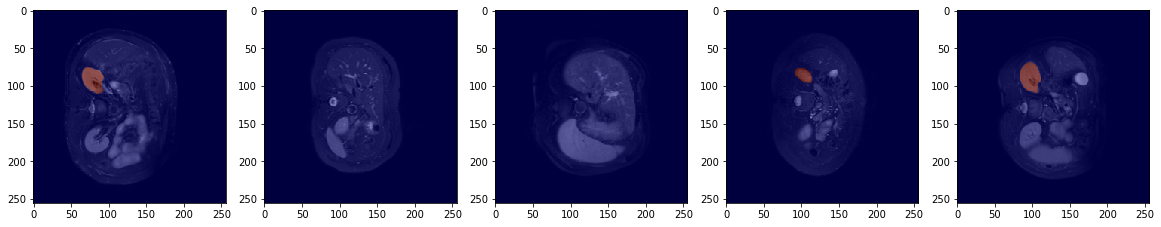

In [59]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask,5,1)

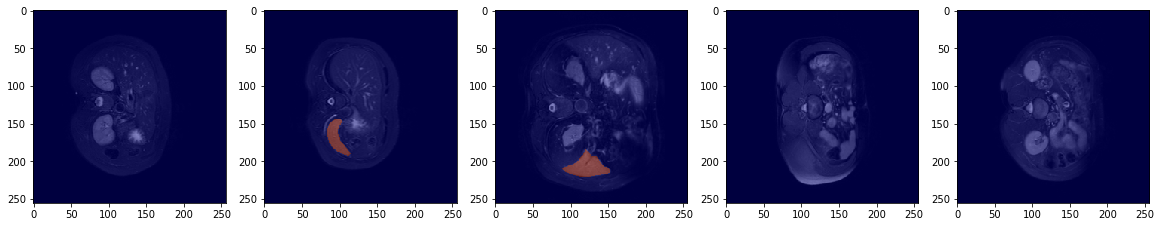

In [62]:
plot_random_images(img,img_mask,5,3)

In [66]:
print(np.unique(img))

[0.00000000e+00 1.00974196e-28 1.51461294e-28 ... 2.02000000e+03
 2.04100000e+03 2.04300000e+03]


In [64]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

In [67]:
print(np.unique(imgs_train))

[-0.53052306 -0.53049946 -0.53047585 ... 11.664149   11.790925
 11.8029995 ]


### test

In [69]:
def get_data_test(test_ids = [21,22,32,39]):
    for idx, test_id in tqdm(enumerate(test_ids)):
        image = read_test_exam(test_id)     
        image = preprocess(image)
        print("img {}".format(image.shape))
        if idx > 0:
            test_data = np.concatenate((test_data, image),axis=0)
        else:
            test_data = image
    print("Final shape {}".format(test_data.shape))    
    np.savez_compressed('./dataset/imgs_test', imgs=test_data)

In [70]:
get_data_test()

2it [00:00,  8.78it/s]

img (31, 256, 256, 1)
img (33, 256, 256, 1)


4it [00:00,  8.10it/s]

img (39, 256, 256, 1)
img (26, 256, 256, 1)
Final shape (129, 256, 256, 1)
